# Optimizing NHL Power Play Lineups with Deep Learning

## Project Objective: 
The goal of this project is to develop a deep learning model capapble of predicting the most effective power play lineups for an NHL team based on expected goals per 60 minutes (xG/60). For this project, the Toronto Maple Leafs were selected as the test team. 

Using data from over 1,100 players across the NHL, the model was trained to recognize statistical patterns that lead to greater power play performance, and then used to select the top-performing 5-player combinations. 

## DATA PREPROCESSING

## Data Collection and Preprocessing

Player statistics were collected from two primary sources:

- **Standard player stats** (e.g., goals, assists, power play production, time on ice) were downloaded from the **NHL’s official statistics website**.
- **Advanced analytics** (e.g., expected goals for %, goals for per 60) were obtained from **[Natural Stat Trick](https://www.naturalstattrick.com/)**, a trusted source for NHL advanced metrics.

The data was downloaded and organized by stat category, then merged into one comprehensive player-level dataset.

####  Standard Player Stats (NHL Source)
- **Player** — Player name  
- **Pos** — Position  
- **PPG** — Power Play Goals  
- **PPA** — Power Play Assists  
- **PPP** — Power Play Points  
- **PP Shots** — Power Play Shots  
- **G** — Goals  
- **A** — Assists  
- **P** — Points  
- **P/GP** — Points per Game  

####  Time on Ice Stats
- **TOI** — Total Ice Time  
- **PP TOI** — Power Play Time on Ice  
- **TOI/GP** — Average TOI per Game  
- **PP TOI/GP** — Average PP TOI per Game  
- **Shifts** — Total shifts played  

####  Miscellaneous Stats
- **Hits** — Number of hits delivered  
- **BkS** — Blocked shots  
- **GvA** — Giveaways  
- **TkA** — Takeaways  

####  Advanced Stats (Natural Stat Trick)
- **CF%** — Corsi For %  
- **FF%** — Fenwick For %  
- **xGF%** — Expected Goals For %  
- **GF/60** — Goals For per 60 minutes  
- **GA/60** — Goals Against per 60 minutes  
- **xGF/60** — Expected Goals For per 60  
- **xGA/60** — Expected Goals Against per 60  
- **Sh%** — Shooting %  

Missing values were filled with zeros, and any object-based stats (e.g., strings with commas) were cleaned and converted to numeric format. All numeric features were then standardized using **z-score scaling** with `StandardScaler` to prepare them for model input.

A custom target variable, **xG/60**, was calculated as: 
xG/60 = (xGF%) × (GF/60 + GA/60)

This metric reflects a player’s expected offensive impact in power play scenarios.

Players from the **Toronto Maple Leafs** (based on a roster file `TML_stats.xlsx`) were isolated as the **test set**, while all other NHL players formed the **training set**.


In [15]:
!pip install openpyxl
!pip install tensorflow


  Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl (252.7 MB)


In [16]:
import pandas as pd
import os
import glob

# === 1. Setup Paths ===

# Folder where all Excel and CSV files are stored
folder_path = "/Users/mirandawallace/Desktop/MUN /DSCI 6602 Project Data"

# Print every file in the folder with its full path
# print("📁 Files in folder:")
# for f in os.listdir(folder_path):
#     print(f"-> {repr(f)}")

# Path to the advanced stats CSV
adv_path = os.path.join(folder_path, "advanceStats.csv")

# Path to the Toronto Maple Leafs player list
tml_path = os.path.join(folder_path, "TML_stats.xlsx")


In [17]:
# === 2. Load Excel Files ===

# Helper function: return all files in the folder that match a keyword (e.g., "power play")
def load_files(keyword):
    files = glob.glob(os.path.join(folder_path, "*.xlsx"))  # Get all Excel files
    return [file for file in files if keyword.lower() in file.lower()]

# Helper function: load files and keep only the specified columns
def read_and_clean(files, columns):
    if not files:
        return pd.DataFrame()  # Return empty if no file found
    df = pd.concat([pd.read_excel(f) for f in files], ignore_index=True)
    return df[[col for col in columns if col in df.columns]]  # Keep only expected columns

# Load each category of stats using the above helpers
power_play_df = read_and_clean(load_files("power play"), ['Player', 'Pos', 'PPG', 'PPA', 'PPP', 'PP Shots'])
summary_df     = read_and_clean(load_files("summary"),     ['Player', 'Pos', 'G', 'A', 'P', 'P/GP'])
toi_df         = read_and_clean(load_files("time on ice"), ['Player', 'Pos', 'TOI', 'PP TOI', 'TOI/GP', 'PP TOI/GP', 'Shifts'])
misc_df        = read_and_clean(load_files("miscellaneous"), ['Player', 'Pos', 'Hits', 'BkS', 'GvA', 'TkA'])


In [18]:
# === 3. Load & Clean Advanced Stats CSV ===

# Load the advanced stats CSV
adv_df = pd.read_csv(adv_path)

# Group by player and position, then aggregate stats
adv_df = adv_df.groupby(['Player', 'Position']).agg({
    "GP": "sum",            # Total games played
    "GF%": "mean",          # Goal share %
    "SF%": "mean",          # Shot share %
    "FF%": "mean",          # Fenwick %
    "CF%": "mean",          # Corsi %
    "xGF%": "mean",         # Expected Goals For %
    "GF/60": "mean",        # Goals For per 60 mins
    "GA/60": "mean",        # Goals Against per 60 mins
    "SF/60": "mean",        # Shots For per 60
    "FF/60": "mean",        # Fenwick For per 60
    "xGA/60": "mean",       # Expected Goals Against per 60
    "Sh%": "mean"           # Shooting %
}).reset_index()

# Rename 'Position' to 'Pos' to match other datasets
adv_df.rename(columns={"Position": "Pos"}, inplace=True)


In [19]:
# === 4. Merge All Data ===

# Merge each dataset one-by-one using outer join on 'Player' and 'Pos'
merged_df = power_play_df.merge(summary_df, on=['Player', 'Pos'], how='outer')
merged_df = merged_df.merge(toi_df, on=['Player', 'Pos'], how='outer')
merged_df = merged_df.merge(misc_df, on=['Player', 'Pos'], how='outer')
merged_df = merged_df.merge(adv_df, on=['Player', 'Pos'], how='outer')

# At this point, merged_df contains all the stats for each player


In [20]:
# === 5. Split into Train / Test (based on Leafs roster) ===

# Load Maple Leafs players
tml_df = pd.read_excel(tml_path)

# Test set: players who are in the Leafs roster
test_set = merged_df[merged_df['Player'].isin(tml_df['Player'])]

# Train set: all other players
train_set = merged_df[~merged_df['Player'].isin(tml_df['Player'])]


In [21]:
# === 6. Fill missing values (replace NaN with 0) ===

# Create clean DataFrames and avoid chained assignment warning
train_set = train_set.fillna(0)
test_set = test_set.fillna(0)


In [22]:
# === 7. Create target variable xG/60 ===

# xG/60 is a custom metric = xGF% * (GF/60 + GA/60)
train_set["xG/60"] = (train_set["xGF%"] / 100) * (train_set["GF/60"] + train_set["GA/60"])
test_set["xG/60"] = (test_set["xGF%"] / 100) * (test_set["GF/60"] + test_set["GA/60"])


In [23]:
# === 8. Save processed datasets to CSV ===

# Save to same folder as source files
train_path = os.path.join(folder_path, "final_project_train_set.csv")
test_path  = os.path.join(folder_path, "final_project_test_set.csv")

train_set.to_csv(train_path, index=False)
test_set.to_csv(test_path, index=False)

print("✅ Preprocessing complete! Files saved locally:")
print("Train Set →", train_path)
print("Test Set  →", test_path)


✅ Preprocessing complete! Files saved locally:
Train Set → /Users/mirandawallace/Desktop/MUN /DSCI 6602 Project Data/final_project_train_set.csv
Test Set  → /Users/mirandawallace/Desktop/MUN /DSCI 6602 Project Data/final_project_test_set.csv


In [24]:
# Show first 5 rows of each set
print("Train Set:")
print(train_set.head(10))

print("\n Test Set:")
print(test_set.head(10))


Train Set:
          Player Pos   PPG   PPA   PPP  PP Shots     G      A      P  P/GP  \
0     A.J. Greer   L   1.0   0.0   1.0       1.0  12.0   14.0   26.0  0.20   
1   Aaron Ekblad   D  12.0  31.0  43.0     125.0  33.0   80.0  113.0  0.62   
2      Aatu Raty   C   0.0   0.0   0.0       1.0   2.0    1.0    3.0  0.20   
3   Adam Beckman   L   0.0   0.0   0.0       0.0   0.0    3.0    3.0  0.13   
4   Adam Boqvist   D   3.0  16.0  19.0      42.0  17.0   39.0   56.0  0.42   
5    Adam Brooks   C   0.0   0.0   0.0       0.0   2.0    1.0    3.0  0.12   
6   Adam Edstrom   C   0.0   0.0   0.0       0.0   2.0    0.0    2.0  0.18   
7      Adam Erne   L   0.0   0.0   0.0       3.0  15.0   24.0   39.0  0.24   
8  Adam Fantilli   C   1.0   2.0   3.0      23.0  12.0   15.0   27.0  0.55   
9       Adam Fox   D   7.0  88.0  95.0     114.0  40.0  179.0  219.0  0.94   

   ...        FF%        CF%       xGF%     GF/60     GA/60      SF/60  \
0  ...  51.990000  51.053333  53.856667  2.190000  2.200

## BUILDING THE MODEL

The goal of this model was to predict the **expected goals per 60 minutes (xG/60)** for 5-player power play lineups, based on individual player statistics. A **Multi-Layer Perceptron (MLP)** regression model was selected for this task due to its ability to learn complex, nonlinear interactions between features.

#### Feature Construction

Each lineup consisted of:
- 1 Center
- 1 Left Wing
- 1 Right Wing
- 2 Defensemen

The individual features for each player in the lineup were concatenated into a single feature vector. For example, if there were 20 features per player, each input to the model was a 100-dimensional vector (5 players × 20 features).

####  Model Architecture

The model was built using TensorFlow and Keras with the following architecture:

- **Input Layer** — Flattened lineup feature vector  
- **Dense Layer (256 units)** — ReLU activation  
- **Batch Normalization** — Normalize layer output  
- **Dropout (0.3)** — Prevent overfitting  
- **Dense Layer (128 units)** — ReLU activation  
- **Batch Normalization**  
- **Dropout (0.3)**  
- **Dense Layer (64 units)** — ReLU activation  
- **Output Layer (1 unit)** — Linear activation (for xG/60 prediction)

####  Training Setup

- **Loss Function:** Mean Squared Error (MSE)  
- **Optimizer:** Adam (learning rate = 0.001)  
- **Metrics Tracked:** Mean Absolute Error (MAE)  
- **Epochs:** 100  
- **Batch Size:** 32  
- **Validation Split:** 20% of training data used for validation

The model was trained on approximately **100,000 randomly generated lineups** using non-Leafs players (the training set). Input features were standardized using `StandardScaler`.

####  Evaluation Strategy

After training, the model was used to evaluate **100,000 test lineups** generated from only **Toronto Maple Leafs players**. Each lineup’s predicted xG/60 was calculated, and the model returned:
- The **optimal lineup** with the highest predicted xG/60
- The **top 10 lineups** overall, ranked by predicted offensive potential



In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


Fontconfig warning: ignoring UTF-8: not a valid region tag


### Step 1: Preprocess, Clean, and Scale Features

In [26]:
# Copy train and test sets to avoid modifying the originals
train_df = train_set.copy()
test_df = test_set.copy()

# Columns to use as features (drop name, position, and target)
exclude_cols = ['Player', 'Pos', 'xG/60']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# Clean object-type columns: remove commas and convert to numbers
for col in feature_cols:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].str.replace(',', '')
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].str.replace(',', '')
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# Fill any missing values with 0
train_df[feature_cols] = train_df[feature_cols].fillna(0)
test_df[feature_cols] = test_df[feature_cols].fillna(0)

# Scale the features
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])
train_df_scaled = train_df.copy()
train_df_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
test_df_scaled = test_df.copy()
test_df_scaled[feature_cols] = scaler.transform(test_df[feature_cols])


### Step 2: Generate Random Lineups

In [27]:
# Generate random 5-player lineups (C, RW, LW, D, D) from train set
def generate_random_lineups(centers, right_wings, left_wings, defensemen, sample_size=1000):
    center_indices = list(centers.index)
    rw_indices = list(right_wings.index)
    lw_indices = list(left_wings.index)
    defense_indices = list(defensemen.index)
    lineups = []

    for _ in range(sample_size):
        c = np.random.choice(center_indices)
        rw = np.random.choice(rw_indices)
        lw = np.random.choice(lw_indices)
        d_pair = np.random.choice(defense_indices, size=2, replace=False)
        lineup = (c, rw, lw, (d_pair[0], d_pair[1]))
        lineups.append(lineup)
    return lineups

# Filter by position
centers_train = train_df_scaled[train_df_scaled['Pos'] == 'C']
right_wings_train = train_df_scaled[train_df_scaled['Pos'] == 'R']
left_wings_train = train_df_scaled[train_df_scaled['Pos'] == 'L']
defensemen_train = train_df_scaled[train_df_scaled['Pos'] == 'D']

# Generate 100,000 random training lineups
train_lineups = generate_random_lineups(
    centers_train, right_wings_train, left_wings_train, defensemen_train, sample_size=100000
)


### Step 3: Convert Lineups to Model Inputs

In [28]:
def create_lineup_features(lineups, df_scaled, feature_cols):
    lineup_features = []
    lineup_ids = []
    for lineup in lineups:
        c, rw, lw, (d1, d2) = lineup
        c_feats = df_scaled.loc[c, feature_cols].values
        rw_feats = df_scaled.loc[rw, feature_cols].values
        lw_feats = df_scaled.loc[lw, feature_cols].values
        d1_feats = df_scaled.loc[d1, feature_cols].values
        d2_feats = df_scaled.loc[d2, feature_cols].values
        features = np.concatenate([c_feats, rw_feats, lw_feats, d1_feats, d2_feats])
        lineup_features.append(features)
        lineup_ids.append((c, rw, lw, d1, d2))
    return np.array(lineup_features, dtype=np.float32), lineup_ids

X_train_lineups, train_lineup_ids = create_lineup_features(train_lineups, train_df_scaled, feature_cols)

# Create target values (average xG/60 for each lineup)
y_train_lineups = np.array([
    train_df.loc[list(lineup), 'xG/60'].mean()
    for lineup in train_lineup_ids
])


### Step 4: Build & Train the Neural Network

In [34]:
input_dim = X_train_lineups.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  # Predict xG/60
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

history = model.fit(
    X_train_lineups, y_train_lineups,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,129 (313.00 KB)

 Trainable params: 79,361 (310.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 751us/step - loss: 0.2763 - mae: 0.3651 - val_loss: 0.0400 - val_mae: 0.1718
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - loss: 0.0330 - mae: 0.1438 - val_loss: 0.0302 - val_mae: 0.1520
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - loss: 0.0197 - mae: 0.1108 - val_loss: 0.0089 - val_mae: 0.0767
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - loss: 0.0145 - mae: 0.0950 - val_loss: 0.0054 - val_mae: 0.0588
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 704us/step - loss: 0.0109 - mae: 0.0821 - val_loss: 0.0025 - val_mae: 0.0391
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 708us/step - loss: 0.0090 - mae: 0.0742 - val_loss: 0.0034 - val_mae: 0.0485
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - loss: 0.0073 - mae: 0.0666 - val_loss: 0.0020 - val_mae: 0.0339
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - loss: 0.0065 - mae: 0.0631 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 9/100
2500

### Step 5: Evaluate Lineups on Leafs Test Set

In [35]:
# Filter positions from test set
centers_test = test_df_scaled[test_df_scaled['Pos'] == 'C']
right_wings_test = test_df_scaled[test_df_scaled['Pos'] == 'R']
left_wings_test = test_df_scaled[test_df_scaled['Pos'] == 'L']
defensemen_test = test_df_scaled[test_df_scaled['Pos'] == 'D']

# Generate test lineups
test_lineups = generate_random_lineups(
    centers_test, right_wings_test, left_wings_test, defensemen_test, sample_size=100000
)

# Turn them into features
X_test_lineups, test_lineup_ids = create_lineup_features(test_lineups, test_df_scaled, feature_cols)

# Predict xG/60 for each lineup
predicted_xG60 = model.predict(X_test_lineups)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step


### Step 6: Show the Best Lineups

In [36]:
# Best predicted lineup
best_idx = predicted_xG60.argmax()
best_lineup_ids = test_lineup_ids[best_idx]
optimal_lineup = test_df.loc[list(best_lineup_ids), ['Player', 'Pos']]

print("\n Optimal Power Play Lineup for Toronto Maple Leafs:")
print(optimal_lineup)
print(f"\nPredicted xG/60: {predicted_xG60[best_idx][0]:.2f}")



 Optimal Power Play Lineup for Toronto Maple Leafs:
                 Player Pos
134     Auston Matthews   C
947        Mitch Marner   R
912     Michael Bunting   L
309       Conor Timmins   D
1263  Timothy Liljegren   D

Predicted xG/60: 3.28


### Step 7: Show Top N Lineups

In [37]:
top_n = 10
top_indices = predicted_xG60.flatten().argsort()[-top_n:][::-1]

for rank, idx in enumerate(top_indices, 1):
    lineup_ids = test_lineup_ids[idx]
    lineup = test_df.loc[list(lineup_ids), ['Player', 'Pos']]
    print(f"\nTop {rank} Lineup (xG/60: {predicted_xG60[idx][0]:.2f}):")
    print(lineup)



Top 1 Lineup (xG/60: 3.28):
                 Player Pos
134     Auston Matthews   C
947        Mitch Marner   R
912     Michael Bunting   L
309       Conor Timmins   D
1263  Timothy Liljegren   D

Top 2 Lineup (xG/60: 3.28):
                 Player Pos
134     Auston Matthews   C
947        Mitch Marner   R
912     Michael Bunting   L
309       Conor Timmins   D
1263  Timothy Liljegren   D

Top 3 Lineup (xG/60: 3.28):
                Player Pos
134    Auston Matthews   C
1369  William Nylander   R
912    Michael Bunting   L
309      Conor Timmins   D
835      Mark Giordano   D

Top 4 Lineup (xG/60: 3.26):
              Player Pos
134  Auston Matthews   C
493    Ilya Mikheyev   R
912  Michael Bunting   L
309    Conor Timmins   D
672      Jordie Benn   D

Top 5 Lineup (xG/60: 3.20):
                Player Pos
134    Auston Matthews   C
1369  William Nylander   R
1302    Tyler Bertuzzi   L
672        Jordie Benn   D
309      Conor Timmins   D

Top 6 Lineup (xG/60: 3.20):
              Pl

### Step 8: Visulaize Training Performance

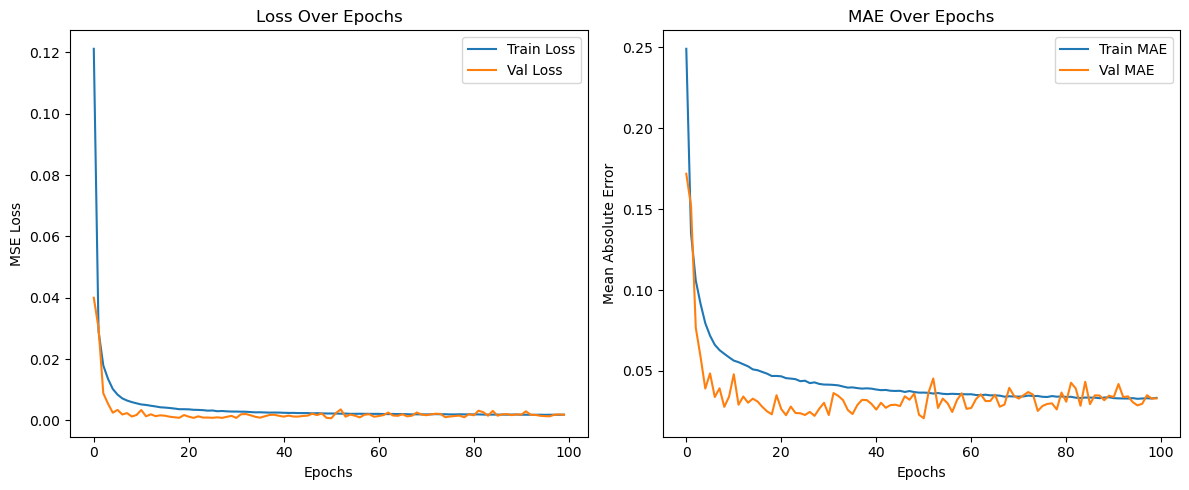

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


###  Model Training Interpretation

The model’s training performance was evaluated using two key metrics:

- **Mean Squared Error (MSE)** — measures the average squared difference between predicted and actual xG/60
- **Mean Absolute Error (MAE)** — measures the average absolute difference between predicted and actual xG/60

#### Loss Over Epochs (MSE)

The loss plot shows that both the training and validation loss decrease rapidly within the first 15–20 epochs and then plateau at a low value. This indicates that the model quickly learned the underlying patterns in the data.

- The **training loss** steadily decreases and stabilizes
- The **validation loss** closely follows the training curve without diverging

There is no indication of overfitting, as the validation loss does not increase over time. The final loss values are very low, suggesting that the model is making small errors when predicting xG/60.

#### MAE Over Epochs

The MAE plot tells a similar story. The average error on both the training and validation sets dropped sharply early in training and leveled out below 0.05.

- The final **validation MAE** remained low and stable
- This suggests that the model's predictions are, on average, within **±0.04 xG/60** of the actual values




Overall, these results indicate that the model converged quickly and generalizes well. The close alignment of training and validation curves in both MSE and MAE plots shows that the model is not overfitting and maintains good predictive performance on unseen lineups.


###  Insights

- The model was able to accurately learn patterns in player performance across multiple statistical categories, achieving a low mean absolute error (~0.04) when predicting xG/60 for randomly generated lineups.
- Key offensive contributors such as **Auston Matthews**, **Mitch Marner**, and **Michael Bunting** consistently appeared in top-performing lineups, suggesting the model effectively identified high-impact players.
- Using players from all NHL teams for training allowed the model to learn generalizable patterns, which transferred well when evaluating combinations specific to the Toronto Maple Leafs.
- The use of advanced stats (e.g., xGF%, GF/60) from **Natural Stat Trick** appeared to significantly boost predictive power compared to traditional scoring stats alone.



###  Conclusion

This project demonstrated that deep learning, specifically a **Multi-Layer Perceptron (MLP)**, can be effectively applied to optimize NHL power play lineups using player-level statistics. The model learned to evaluate combinations of players and ranked potential lineups based on expected offensive output (xG/60).

By evaluating thousands of possible combinations, the model produced actionable lineup suggestions tailored to a specific team — in this case, the **Toronto Maple Leafs**. This approach offers a scalable and data-driven way to support coaching decisions.



###  Future Work

- **Chemistry effects:** Incorporating player pairing history or on-ice synergy data to account for real-world chemistry between players.
- **Context-aware modeling:** Introducing game situation variables (e.g., opponent, score differential, zone starts) to make predictions more dynamic.
- **Alternative model types:** Testing other deep learning architectures (e.g., recurrent or attention-based models) to capture temporal player trends.
- **Reinforcement learning:** Framing the problem as a sequence of decisions (e.g., full game strategy) rather than one-shot lineup optimization.
- **Penalty kill modeling:** Applying the same approach to predict optimal defensive lineups and special teams configurations.

